<a href="https://colab.research.google.com/github/Nuwanthapasindu/paddy-disease-prediction-ai-model/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip "/content/drive/MyDrive/ML_Learning/paddy-disease-prediction-ai-model/archive.zip"

Streaming output truncated to the last 5000 lines.
  inflating: paddy-disease-classification/train_images/hispa/104947.jpg  
  inflating: paddy-disease-classification/train_images/hispa/104955.jpg  
  inflating: paddy-disease-classification/train_images/hispa/104959.jpg  
  inflating: paddy-disease-classification/train_images/hispa/104960.jpg  
  inflating: paddy-disease-classification/train_images/hispa/104967.jpg  
  inflating: paddy-disease-classification/train_images/hispa/104969.jpg  
  inflating: paddy-disease-classification/train_images/hispa/104973.jpg  
  inflating: paddy-disease-classification/train_images/hispa/104976.jpg  
  inflating: paddy-disease-classification/train_images/hispa/104979.jpg  
  inflating: paddy-disease-classification/train_images/hispa/104981.jpg  
  inflating: paddy-disease-classification/train_images/hispa/104985.jpg  
  inflating: paddy-disease-classification/train_images/hispa/104986.jpg  
  inflating: paddy-disease-classification/train_images/hispa/

In [4]:
data_set_path = "/content/paddy-disease-classification"
data_set_train_path = os.path.join(data_set_path, "train_images")
print(data_set_train_path)
data_set_test_path = os.path.join(data_set_path, "test_images")

/content/paddy-disease-classification/train_images


In [5]:
IMAGE_SIZE = 480
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [6]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_set_train_path,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 19131 files belonging to 10 classes.


# Data Visualization

In [7]:
class_names = train_dataset.class_names
class_names

['bacterial_leaf_blight',
 'bacterial_leaf_streak',
 'bacterial_panicle_blight',
 'blast',
 'brown_spot',
 'dead_heart',
 'downy_mildew',
 'hispa',
 'normal',
 'tungro']

In [8]:
def calculate_class_counts(dataset,folder_path):
  class_names = dataset.class_names
  class_counts = {}
  for class_name in class_names:
    class_dir = os.path.join(folder_path, class_name)
    class_counts[class_name] = len(os.listdir(class_dir))
  return class_counts


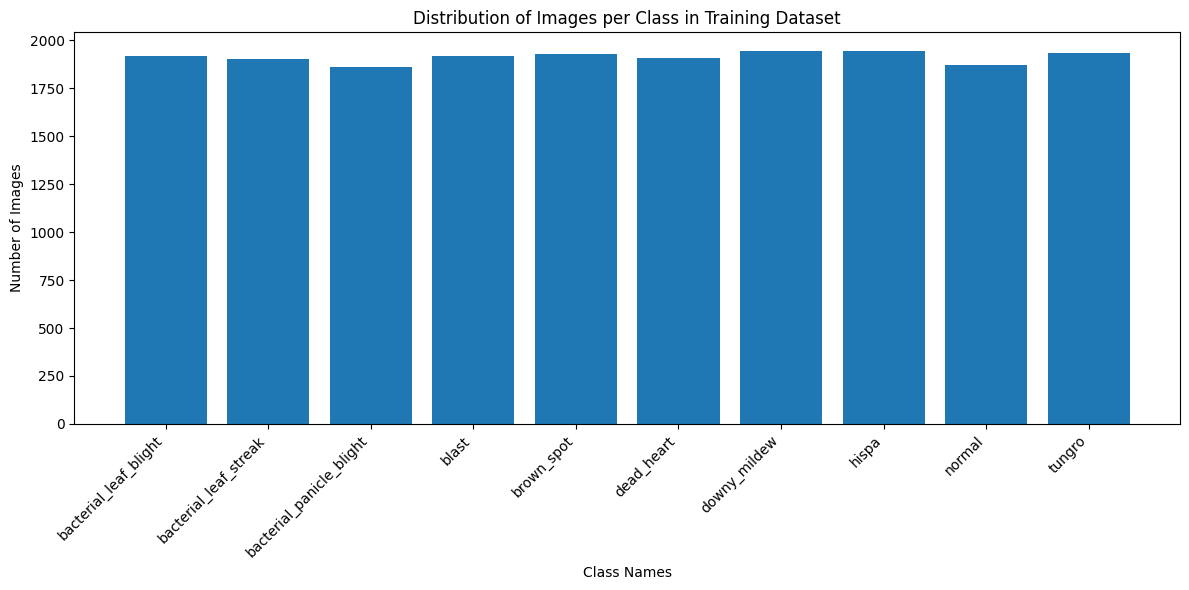

In [9]:
train_dataset_class_counts = calculate_class_counts(train_dataset,data_set_train_path)
plt.figure(figsize=(12, 6))
plt.bar(train_dataset_class_counts.keys(), train_dataset_class_counts.values())
plt.xticks(rotation=45, ha='right')
plt.xlabel("Class Names")
plt.ylabel("Number of Images")
plt.title("Distribution of Images per Class in Training Dataset")
plt.tight_layout()
plt.show()

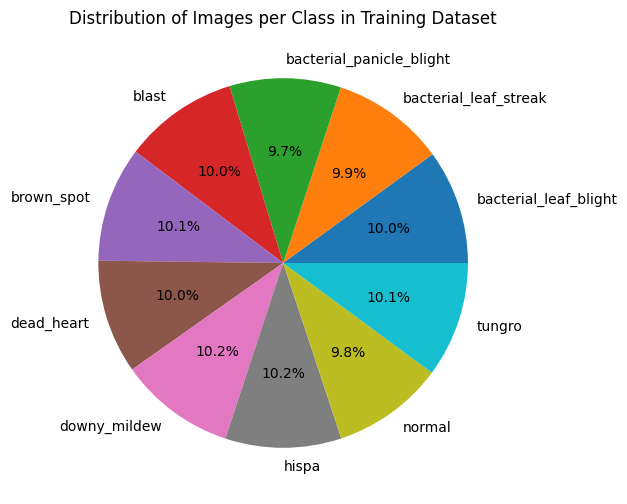

In [10]:
plt.figure(figsize=(12, 6))
plt.pie(train_dataset_class_counts.values(), labels=train_dataset_class_counts.keys(), autopct='%1.1f%%')
plt.title("Distribution of Images per Class in Training Dataset")
plt.show()

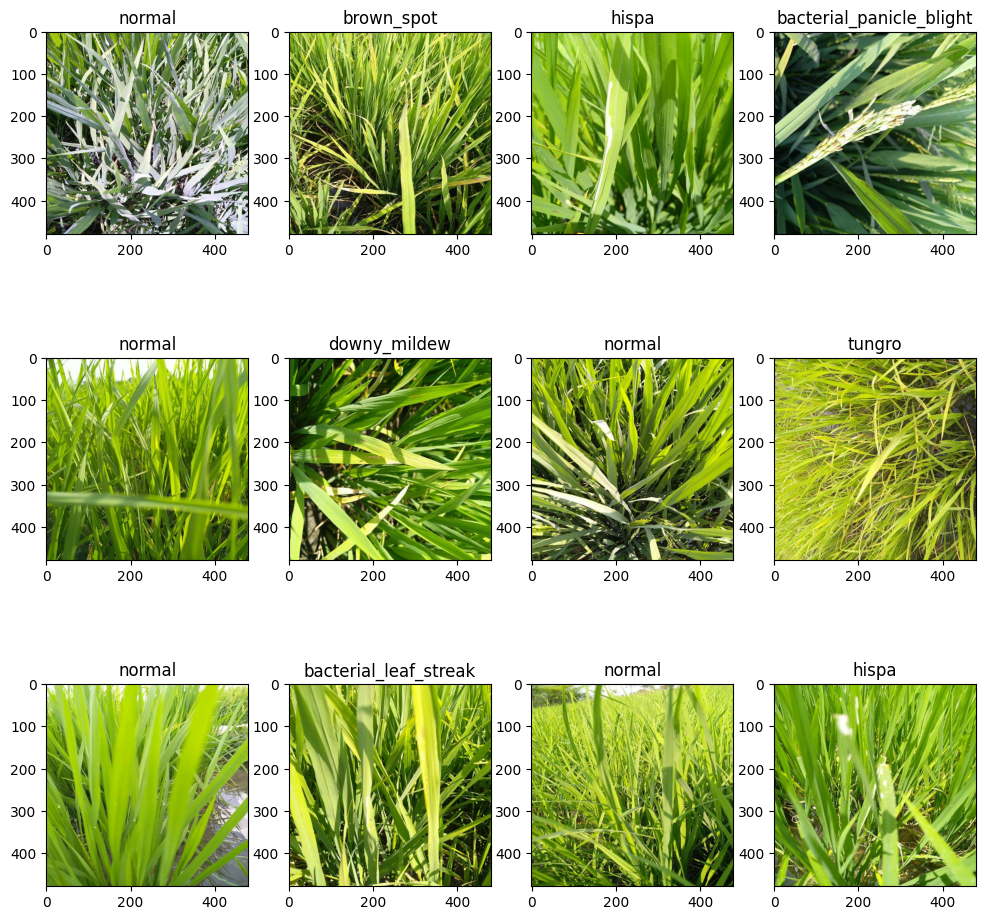

In [11]:
plt.figure(figsize=(12, 12))
for image_batch, label_batch in train_dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])

## visiualize pre splitted test data

In [20]:
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    data_set_test_path,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 10407 files belonging to 10 classes.


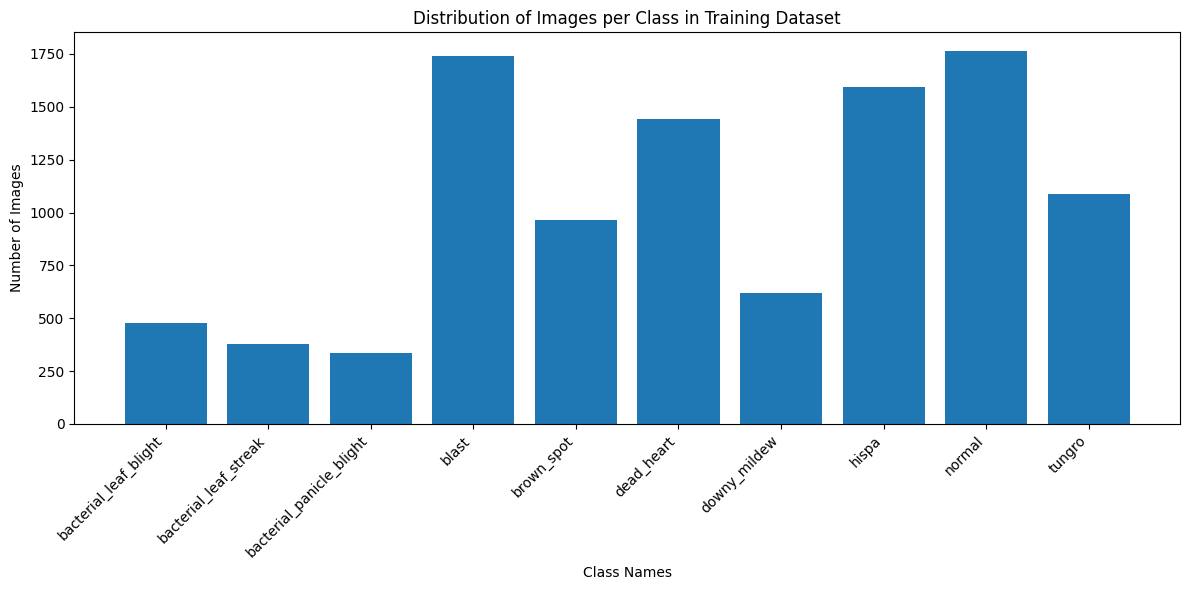

In [16]:
test_data_class_count = calculate_class_counts(test_data,data_set_test_path)
plt.figure(figsize=(12, 6))
plt.bar(test_data_class_count.keys(), test_data_class_count.values())
plt.xticks(rotation=45, ha='right')
plt.xlabel("Class Names")
plt.ylabel("Number of Images")
plt.title("Distribution of Images per Class in Training Dataset")
plt.tight_layout()
plt.show()

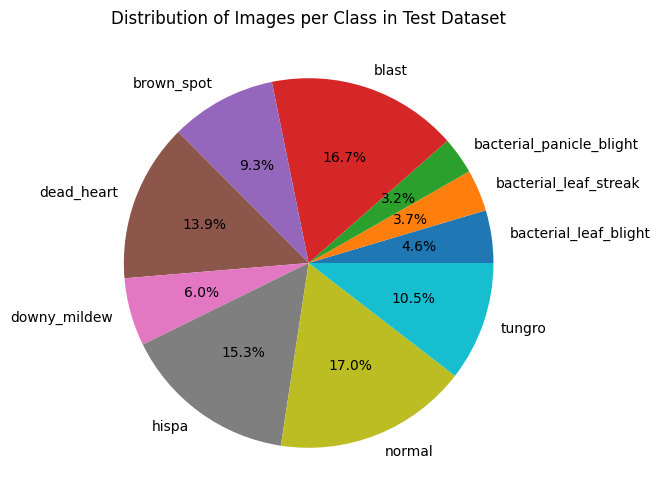

In [17]:
plt.figure(figsize=(12, 6))
plt.pie(test_data_class_count.values(), labels=test_data_class_count.keys(), autopct='%1.1f%%')
plt.title(f"Distribution of Images per Class in Test Dataset - {}")
plt.show()

## check pre defined test data are same or not

In [39]:
def extract_file_names_from_dataset(data_test_classes,data_set_path):
  train_data_names = []
  for class_name in data_test_classes:
      train_data_names.extend(os.listdir(os.path.join(data_set_path,class_name)))
  return set(train_data_names)

is_smae =  extract_file_names_from_dataset(train_dataset.class_names,data_set_train_path).intersection(extract_file_names_from_dataset(test_data.class_names,data_set_test_path))
if is_smae:
  print("test data and train data are same")
else:
  print("test data and train data are not same")x

test data and train data are same
